# IMPORTS

In [1]:
import arff
import pandas as pd
import numpy as np
import math
import os
import random
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# PREPROCESSING
### ARFF to DataFrame

In [2]:
## Function that joins ARFF files into single pandas dataframe. Assumes files have a systematic format,
## e.g. phone_accelerometer_001.arff, where the number (unique) would change for every set of data.
# Inputs: File prefix & suffix before identifying number, Range of file numbers
# Output: DataFrame
def arffToDataFrame(directory, prefix, suffix, lo, hi):
    df_list = []
    for i in range(lo, hi+1):
        filename = os.path.join(directory, prefix + str(i) + suffix)
        try:
            data = arff.load(open(filename))
            labels = [label[0] for label in data['attributes']]
            df = pd.DataFrame(data['data'], columns=labels)
            df['class'] = i # Corrects class label to UID. Incorrectly labelled when read from ARFF file.
            df_list.append(df)
        except:
            pass
    
    df_concat = pd.concat(df_list)
    return df_concat

### Convert for each sensor on smartphone (2) & smartwatch (2)

In [3]:
df_phone_accel = arffToDataFrame('phone_accel', 'data_', '_accel_phone.arff', 1600, 1650)
df_phone_gyro = arffToDataFrame('phone_gyro', 'data_', '_gyro_phone.arff', 1600, 1650)
df_watch_accel = arffToDataFrame('watch_accel', 'data_', '_accel_watch.arff', 1600, 1650)
df_watch_gyro = arffToDataFrame('watch_gyro', 'data_', '_gyro_watch.arff', 1600, 1650)

In [4]:
# Sample DataFrame
df_phone_accel.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.235,0.470,0.275,0.020,0.000,0.0,0.0,0.0,0.0,...,0.486106,0.479859,-0.550668,0.049864,0.121354,-0.251024,0.164468,-0.110722,10.05180,1600
1,A,0.275,0.440,0.270,0.015,0.000,0.0,0.0,0.0,0.0,...,0.479571,0.473409,-0.633171,0.072129,0.161492,-0.386416,0.215680,-0.034375,10.11710,1600
2,A,0.320,0.430,0.245,0.000,0.005,0.0,0.0,0.0,0.0,...,0.483005,0.476798,-0.659493,0.087043,0.162157,-0.325151,0.272380,-0.077274,9.98384,1600
3,A,0.315,0.495,0.185,0.005,0.000,0.0,0.0,0.0,0.0,...,0.480711,0.474534,-0.712081,0.003810,0.210015,-0.364285,0.203131,0.015328,10.10600,1600
4,A,0.215,0.455,0.325,0.005,0.000,0.0,0.0,0.0,0.0,...,0.468836,0.462811,-0.534933,0.047553,0.275833,-0.216423,0.238500,-0.009870,10.05210,1600


In [5]:
# of Users
len(df_phone_accel['class'].unique())

50

### Algorithms to Use for Building Models
API can be found here:
http://scikit-learn.org/stable/modules/classes.html

In [6]:
algorithms = [RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier()]

# PERSONAL MODELS

In [10]:
## Function that buids and tests a list of given machine learning algorithms.
# Inputs: DataFrame (data),
#         List of algorithms (from sklearn - e.g. sklearn.tree.DecisionTreeClassifier),
#         Name of label being tested (e.g. 'ACTIVITY' for Activity Recognition)
# Outputs: Individual scores (1 per algorithm x Number of users)
#          Confunsion Matrices (1 per algorithm x Number of users)
def runPersonalModels(df, algorithms, label_name):
    # List to hold scores (list of lists since there are several algorithms per user)
    individual_scores = []
    individual_confusion_matrices = []
    
    # Build a model per user
    for user in df['class'].unique():
        scores = []
        confusion_matrices = []
        data = df.loc[df['class'] == user]
        
        # For every user, build a model per algorithm
        for algorithm in algorithms:
            # 10-Fold Cross Validation (cv=10)
            # See http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
            predicted = cross_val_predict(algorithm, data.drop(label_name, axis=1), data[label_name], cv=10)
            
            # Accuracy: % of Correctly Classified Labels
            # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
            accuracy = accuracy_score(data[label_name], predicted)
            
            # Compute confusion matrix.
            # Use full list of activities as labels (to account for missing data)
            # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
            cm = confusion_matrix(data[label_name], predicted, labels=df[label_name].unique())
            
            # Output Status
            #print(algorithm)
            print(accuracy)
            
            # Add score and confusion matrix for the algorithm
            scores.append(accuracy)
            confusion_matrices.append(cm)
        
        # Add score and confusion matrix for the user
        individual_scores.append(scores)
        individual_confusion_matrices.append(confusion_matrices)
    
    return individual_scores, individual_confusion_matrices

In [11]:
## Function that aggregates individual scores and confusion matrices (returned by runPersonalModels function)
# Input: Scores (per algorithm per user)
#        Confusion Matrices (per algorithm per user)
#        List of labels for labelling the confusion matrices
# Output: Scores (per algorithm), Confusion Matrices (per algorithm)
def aggregateIndividualScores(scores, cms, labels):
    avg_scores = []
    stds = []
    agg_cms = []
    
    # Average individual scores for each algorithm 
    for i in range(len(scores[0])):
        avg_scores.append(np.mean([x[i] for x in scores]))
        stds.append(np.std([x[i] for x in scores]))
    
    # Aggregate individual confusion matrices
    cms = [sum(i) for i in zip(*cms)] # As list of arrays
    
    # Convert to a dataframe for visualization
    for cm in cms:
        cms_df = pd.DataFrame(cm, columns=labels, index=labels)
        agg_cms.append(cms_df)
    
    # Add column for accuracy per activity
    for cm in agg_cms:
        per_act = []
        
        # Calculate % of correct labels
        for act in cm.columns:
            percent_correct = (cm.loc[act][act] / cm.loc[act].sum()) * 100.0
            per_act.append(percent_correct)
        
        cm['PER_ACT_ACC'] = per_act
    
    return avg_scores, stds, agg_cms

## Results
### Watch Accel

In [168]:
personal_scores1, personal_cms1 = runPersonalModels(df_watch_accel, algorithms, 'ACTIVITY')

0.938837920489
0.926605504587
0.917431192661
0.947530864198
0.901234567901
0.885802469136
0.854938271605
0.787037037037
0.771604938272
0.907407407407
0.882716049383
0.87962962963
0.873456790123
0.848765432099
0.759259259259
0.812121212121
0.721212121212
0.739393939394
0.895061728395
0.876543209877
0.83950617284
0.884498480243
0.808510638298
0.793313069909
0.85
0.814705882353
0.835294117647
0.882183908046
0.813218390805
0.827586206897
0.891975308642
0.858024691358
0.851851851852
0.91049382716
0.848765432099
0.808641975309
0.898773006135
0.849693251534
0.766871165644
0.925925925926
0.913580246914
0.848765432099
0.861111111111
0.83024691358
0.765432098765
0.83660130719
0.839869281046
0.771241830065
0.910447761194
0.841791044776
0.737313432836
0.915032679739
0.888888888889
0.754901960784
0.87714987715
0.818181818182
0.592137592138
0.785074626866
0.740298507463
0.683582089552
0.811274509804
0.754901960784
0.703431372549
0.929012345679
0.873456790123
0.827160493827
0.932098765432
0.879629629

In [89]:
agg_personal_scores1, agg_personal_stds1, agg_personal_cms1 = aggregateIndividualScores(personal_scores1, personal_cms1, df_watch_accel['ACTIVITY'].unique())

In [93]:
agg_personal_cms1[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,723,5,68,0,10,0,1,1,0,2,0,1,77,12,4,0,1,9,79.102845
B,9,828,7,1,1,0,3,2,0,0,0,0,5,26,7,0,0,6,92.513966
C,90,10,635,2,4,0,5,1,1,0,1,1,77,27,14,1,0,32,70.477248
D,0,2,3,728,2,55,3,8,18,17,15,12,1,3,1,29,2,11,80.000000
E,18,0,10,16,795,6,1,4,6,4,7,3,37,0,6,6,0,17,84.935897
F,0,0,1,15,16,824,1,3,7,4,2,8,1,0,0,8,0,1,92.480359
G,1,2,7,7,3,8,759,17,30,13,7,23,0,6,0,1,14,12,83.406593
H,1,1,2,2,1,6,16,712,21,84,14,19,0,3,1,13,3,14,77.984666
I,0,3,3,11,5,15,35,38,617,46,30,73,0,2,0,10,6,22,67.358079
J,0,0,1,6,9,12,6,107,67,632,20,26,0,3,1,17,8,10,68.324324


In [94]:
agg_personal_scores1

[0.87028194865854624, 0.82565384171630862, 0.78734577633295866]

In [71]:
agg_personal_stds1

[0.043010777029216393, 0.052301468575700838, 0.068293521788684697]

### Watch Gyro

In [51]:
personal_scores2, personal_cms2 = runPersonalModels(df_watch_gyro, algorithms, 'ACTIVITY')

0.85626911315
0.782874617737
0.60244648318
0.867283950617
0.83950617284
0.552469135802
0.756172839506
0.691358024691
0.524691358025
0.845679012346
0.762345679012
0.54012345679
0.722222222222
0.598765432099
0.462962962963
0.666666666667
0.645454545455
0.484848484848
0.746913580247
0.716049382716
0.567901234568
0.750759878419
0.723404255319
0.528875379939
0.741176470588
0.691176470588
0.482352941176
0.850574712644
0.807471264368
0.591954022989
0.787037037037
0.771604938272
0.555555555556
0.833333333333
0.814814814815
0.632716049383
0.782208588957
0.739263803681
0.539877300613
0.854938271605
0.833333333333
0.530864197531
0.703703703704
0.70987654321
0.466049382716
0.764705882353
0.71568627451
0.513071895425
0.766467065868
0.751497005988
0.532934131737
0.849673202614
0.777777777778
0.52614379085
0.624691358025
0.540740740741
0.4
0.674626865672
0.650746268657
0.474626865672
0.659259259259
0.577777777778
0.474074074074
0.854938271605
0.796296296296
0.524691358025
0.845679012346
0.80864197530

In [95]:
agg_personal_scores2, agg_personal_stds2, agg_personal_cms2 = aggregateIndividualScores(personal_scores2, personal_cms2, df_watch_gyro['ACTIVITY'].unique())

In [98]:
agg_personal_cms2[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,644,6,96,2,12,0,15,2,2,2,3,7,70,28,5,1,1,10,71.081678
B,19,617,15,6,4,1,19,8,15,12,7,6,11,33,53,4,4,62,68.861607
C,128,32,425,4,13,2,23,12,9,17,2,8,124,53,13,0,3,33,47.169811
D,5,9,19,481,46,79,26,34,26,22,37,27,7,3,4,63,10,11,52.915292
E,35,6,48,78,414,27,43,43,38,34,38,26,27,16,3,22,11,27,44.230769
F,2,4,2,44,20,623,16,17,18,18,26,9,1,0,2,73,13,5,69.764838
G,12,24,22,23,31,34,535,34,42,28,12,21,12,4,6,10,18,40,58.920705
H,11,11,31,43,34,29,68,383,62,56,61,43,9,10,5,12,14,33,41.857923
I,17,33,32,39,59,49,76,95,261,54,48,58,8,16,5,6,17,41,28.555799
J,8,19,37,42,51,57,49,110,74,273,48,59,8,6,5,17,19,43,29.513514


In [99]:
agg_personal_scores2

[0.75690668051047738, 0.7022982598903772, 0.50537330223696419]

In [100]:
agg_personal_stds2

[0.069906067515541806, 0.078930775322829466, 0.063987624365241316]

### Phone Accel

In [56]:
personal_scores3, personal_cms3 = runPersonalModels(df_phone_accel, algorithms, 'ACTIVITY')

0.931464174455
0.919003115265
0.710280373832
0.928746928747
0.904176904177
0.769041769042
0.88679245283
0.870283018868
0.525943396226
0.914425427873
0.880195599022
0.81662591687
0.83800623053
0.859813084112
0.560747663551
0.866995073892
0.847290640394
0.716748768473
0.866043613707
0.841121495327
0.694704049844
0.911227154047
0.88772845953
0.827676240209
0.921161825726
0.900414937759
0.844398340249
0.826797385621
0.81045751634
0.738562091503
0.913366336634
0.841584158416
0.735148514851
0.898514851485
0.844059405941
0.735148514851
0.908415841584
0.841584158416
0.735148514851
0.903465346535
0.851485148515
0.735148514851
0.891089108911
0.834158415842
0.735148514851
0.905940594059
0.834158415842
0.735148514851
0.905940594059
0.836633663366
0.735148514851
0.881188118812
0.887788778878
0.60396039604
0.864197530864
0.820987654321
0.787037037037
0.794594594595
0.758558558559
0.576576576577
0.780898876404
0.755617977528
0.688202247191
0.934579439252
0.90031152648
0.816199376947
0.898901098901
0.

In [101]:
agg_personal_scores3, agg_personal_stds3, agg_personal_cms3 = aggregateIndividualScores(personal_scores3, personal_cms3, df_phone_accel['ACTIVITY'].unique())

In [104]:
agg_personal_cms3[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,1235,11,46,4,3,0,4,0,0,1,1,5,32,9,9,0,2,6,90.277778
B,54,1300,25,1,0,0,6,0,0,0,0,1,24,1,0,0,0,0,92.067989
C,114,30,989,4,10,2,4,1,1,0,0,1,84,14,13,0,0,9,77.507837
D,12,0,30,983,24,49,16,51,32,20,52,37,8,4,0,15,43,5,71.180304
E,32,2,20,35,1056,16,12,11,9,2,5,19,41,47,27,7,23,29,75.807609
F,11,1,5,56,21,868,19,46,19,19,19,83,1,5,2,70,22,10,67.971809
G,16,2,20,34,10,60,955,46,40,33,27,18,3,7,16,29,35,27,69.303338
H,4,1,5,65,14,124,66,686,94,78,94,44,1,3,4,38,27,3,50.777202
I,0,0,2,57,13,47,63,114,723,63,85,61,1,4,4,50,38,6,54.320060
J,3,0,2,28,10,50,69,129,97,669,43,50,1,1,2,53,24,1,54.301948


In [105]:
agg_personal_scores3

[0.88631725308519482, 0.85751878593934583, 0.68368396012145594]

In [106]:
agg_personal_stds3

[0.041900772727443442, 0.046002726552013672, 0.1009885850636363]

### Phone Gyro

In [60]:
personal_scores4, personal_cms4 = runPersonalModels(df_phone_gyro, algorithms, 'ACTIVITY')

0.732087227414
0.707165109034
0.423676012461
0.745679012346
0.738271604938
0.449382716049
0.669781931464
0.601246105919
0.380062305296
0.762962962963
0.733333333333
0.575308641975
0.591900311526
0.538940809969
0.289719626168
0.646913580247
0.545679012346
0.397530864198
0.688473520249
0.570093457944
0.464174454829
0.660574412533
0.629242819843
0.381201044386
0.719626168224
0.638629283489
0.445482866044
0.707236842105
0.651315789474
0.427631578947
0.685358255452
0.638629283489
0.482866043614
0.769470404984
0.713395638629
0.485981308411
0.778816199377
0.688473520249
0.607476635514
0.785185185185
0.728395061728
0.422222222222
0.741433021807
0.676012461059
0.426791277259
0.673684210526
0.631578947368
0.473684210526
0.719626168224
0.707165109034
0.473520249221
0.63696369637
0.53795379538
0.475247524752
0.728395061728
0.666666666667
0.558641975309
0.635514018692
0.566978193146
0.370716510903
0.682584269663
0.620786516854
0.415730337079
0.772585669782
0.694704049844
0.448598130841
0.7102803738

In [107]:
agg_personal_scores4, agg_personal_stds4, agg_personal_cms4 = aggregateIndividualScores(personal_scores4, personal_cms4, df_phone_gyro['ACTIVITY'].unique())

In [112]:
agg_personal_cms4[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,788,19,52,1,3,1,1,5,4,0,1,3,37,11,13,0,2,4,83.386243
B,70,828,29,2,2,0,2,0,0,0,0,0,23,6,4,0,4,2,85.185185
C,110,72,519,6,3,4,11,5,2,4,4,0,98,26,25,0,5,16,57.032967
D,14,7,34,401,58,55,40,59,54,47,66,36,10,12,9,60,29,23,39.546351
E,24,0,25,86,412,42,35,35,20,24,22,17,25,43,42,29,22,64,42.605998
F,6,1,16,90,38,438,52,36,42,38,35,30,6,16,6,63,17,15,46.349206
G,13,5,21,46,45,82,434,39,40,52,18,44,13,17,21,31,14,29,45.020747
H,6,6,14,89,55,83,80,243,73,81,67,49,6,16,8,39,24,19,25.365344
I,7,3,13,99,55,65,52,77,261,71,65,70,9,13,8,39,27,21,27.329843
J,5,1,17,78,38,80,85,102,91,225,42,58,6,12,11,49,20,25,23.809524


In [109]:
agg_personal_scores4

[0.68891301481333822, 0.62851153076201471, 0.43245273753208258]

In [110]:
agg_personal_stds4

[0.058974452522982487, 0.065626720118456716, 0.063050560105052736]

# IMPERSONAL MODELS

In [65]:
## Function that buids and tests a list of given machine learning algorithms.
# Inputs: DataFrame (data),
#         List of algorithms (from sklearn - e.g. sklearn.tree.DecisionTreeClassifier),
#         Name of label being tested (e.g. 'ACTIVITY' for Activity Recognition,
def runImpersonalTests(df, algorithms, label_name):
    # List to hold scores (list of lists since there are several algorithms per user)
    individual_scores = []
    individual_confusion_matrices = []
    
    # Build a model per user (as the test data)
    for user in df['class'].unique():
        scores = []
        confusion_matrices = []
        
        # Split data into training and test. Training data is every user except one, test is remaining user
        train_data = df.loc[df['class'] != user]
        test_data = df.loc[df['class'] == user]
        
        # For every user, build a model per algorithm
        for algorithm in algorithms:
            # Build model and predict
            algorithm.fit(train_data.drop(label_name, axis=1), train_data[label_name])
            predicted = algorithm.predict(test_data.drop(label_name, axis=1))
            
            # Accuracy: % of Correctly Classified Labels
            # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
            accuracy = accuracy_score(test_data[label_name], predicted)
            
            # Compute confusion matrix.
            # Use full list of activities as labels (to account for missing data)
            # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
            cm = confusion_matrix(test_data[label_name], predicted, labels=df[label_name].unique())
            
            # Output Status
            #print(algorithm)
            print(accuracy)
            
            # Add score and confusion matrix for the algorithm
            scores.append(accuracy)
            confusion_matrices.append(cm)
        
        # Add score and confusion matrix for the user
        individual_scores.append(scores)
        individual_confusion_matrices.append(confusion_matrices)
    
    return individual_scores, individual_confusion_matrices

## Results

In [13]:
impersonal_scores1, impersonal_cms1 = runImpersonalTests(df_watch_accel, algorithms, 'ACTIVITY')

0.834862385321
0.703363914373
0.547400611621
0.703703703704
0.45987654321
0.302469135802
0.756172839506
0.66975308642
0.54012345679
0.598765432099
0.574074074074
0.361111111111
0.746913580247
0.583333333333
0.453703703704
0.748484848485
0.590909090909
0.59696969697
0.743827160494
0.574074074074
0.527777777778
0.340425531915
0.322188449848
0.209726443769
0.608823529412
0.541176470588
0.435294117647
0.623563218391
0.471264367816
0.465517241379
0.824074074074
0.706790123457
0.462962962963
0.734567901235
0.62962962963
0.487654320988
0.576687116564
0.457055214724
0.248466257669
0.675925925926
0.614197530864
0.401234567901
0.75
0.682098765432
0.598765432099
0.709150326797
0.71568627451
0.59477124183
0.686567164179
0.558208955224
0.376119402985
0.686274509804
0.578431372549
0.535947712418
0.110565110565
0.105651105651
0.110565110565
0.594029850746
0.459701492537
0.25671641791
0.0245098039216
0.0392156862745
0.0539215686275
0.567901234568
0.395061728395
0.234567901235
0.851851851852
0.76234567

In [14]:
agg_impersonal_scores1, agg_impersonal_stds1, agg_impersonal_cms1 = aggregateIndividualScores(impersonal_scores1, impersonal_cms1, df_watch_accel['ACTIVITY'].unique())

In [15]:
agg_impersonal_cms1[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,337,19,176,0,10,0,48,25,3,12,8,4,194,20,10,1,11,36,36.870897
B,12,679,8,0,12,0,10,1,5,3,8,14,11,93,16,0,13,10,75.865922
C,138,6,445,1,12,0,41,21,4,7,11,9,96,37,18,1,1,53,49.389567
D,2,0,4,319,43,230,9,18,40,41,25,28,0,3,1,118,5,24,35.054945
E,26,0,5,68,451,15,33,36,24,15,80,43,53,3,4,35,13,32,48.183761
F,1,0,1,179,1,451,0,32,30,35,46,11,1,0,0,91,1,11,50.617284
G,41,4,49,13,32,2,479,12,50,25,38,49,46,4,6,1,47,12,52.637363
H,5,0,26,21,28,33,38,322,38,133,41,39,23,9,7,41,17,92,35.268346
I,6,0,13,80,44,41,70,59,171,102,85,121,4,4,6,26,38,46,18.668122
J,10,7,6,65,20,35,35,132,94,263,53,90,2,2,10,30,19,52,28.432432


In [16]:
agg_impersonal_scores1

[0.6523103043981946, 0.54739497588388952, 0.41986571288402602]

In [17]:
agg_impersonal_stds1

[0.15856253268364287, 0.15191518487567943, 0.13010685177341696]

In [18]:
impersonal_scores2, impersonal_cms2 = runImpersonalTests(df_watch_gyro, algorithms, 'ACTIVITY')

0.715596330275
0.645259938838
0.2874617737
0.58950617284
0.382716049383
0.20987654321
0.626543209877
0.524691358025
0.302469135802
0.546296296296
0.364197530864
0.182098765432
0.570987654321
0.537037037037
0.283950617284
0.509090909091
0.448484848485
0.19696969697
0.58950617284
0.549382716049
0.314814814815
0.352583586626
0.258358662614
0.161094224924
0.511764705882
0.432352941176
0.294117647059
0.454022988506
0.41091954023
0.23275862069
0.765432098765
0.679012345679
0.302469135802
0.694444444444
0.62962962963
0.361111111111
0.546012269939
0.432515337423
0.242331288344
0.638888888889
0.475308641975
0.277777777778
0.601851851852
0.521604938272
0.246913580247
0.656862745098
0.588235294118
0.267973856209
0.520958083832
0.35628742515
0.22754491018
0.532679738562
0.480392156863
0.179738562092
0.083950617284
0.0493827160494
0.0617283950617
0.382089552239
0.337313432836
0.197014925373
0.0666666666667
0.0666666666667
0.0962962962963
0.54012345679
0.490740740741
0.234567901235
0.722222222222
0.

In [19]:
agg_impersonal_scores2, agg_impersonal_stds2, agg_impersonal_cms2 = aggregateIndividualScores(impersonal_scores2, impersonal_cms2, df_watch_gyro['ACTIVITY'].unique())

In [34]:
agg_impersonal_cms2[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,414,16,166,2,10,3,11,10,9,10,6,2,134,52,19,0,18,24,45.695364
B,38,336,43,26,4,5,33,30,16,3,13,7,14,75,104,7,48,94,37.500000
C,193,34,214,8,27,1,31,15,14,17,5,10,180,65,24,0,11,52,23.751387
D,12,10,22,281,99,115,29,36,22,41,43,33,18,3,4,116,7,18,30.913091
E,37,9,61,124,260,41,72,48,32,61,43,35,43,7,3,30,16,14,27.777778
F,7,2,6,76,38,251,36,36,34,62,32,51,1,0,0,218,41,2,28.107503
G,36,27,71,33,86,64,165,59,77,69,25,34,26,10,5,27,41,53,18.171806
H,27,41,29,51,67,76,88,128,76,75,60,57,18,7,8,20,37,50,13.989071
I,31,19,43,66,60,71,116,95,81,91,54,56,20,13,5,19,27,47,8.862144
J,22,8,48,66,88,103,98,75,94,92,39,62,30,9,4,37,26,24,9.945946


In [21]:
agg_impersonal_scores2

[0.54508740087481922, 0.4544216304977004, 0.24476869961113326]

In [22]:
agg_impersonal_stds2

[0.14341501306954615, 0.12685426238284053, 0.061429136804630372]

In [23]:
impersonal_scores3, impersonal_cms3 = runImpersonalTests(df_phone_accel, algorithms, 'ACTIVITY')

0.389408099688
0.305295950156
0.258566978193
0.289926289926
0.277641277641
0.2457002457
0.259433962264
0.179245283019
0.132075471698
0.288508557457
0.21271393643
0.305623471883
0.336448598131
0.305295950156
0.302180685358
0.302955665025
0.238916256158
0.307881773399
0.18691588785
0.133956386293
0.0965732087227
0.227154046997
0.148825065274
0.227154046997
0.304979253112
0.203319502075
0.211618257261
0.307189542484
0.160130718954
0.179738562092
1.0
1.0
0.982673267327
1.0
1.0
0.99504950495
1.0
1.0
0.99504950495
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.980198019802
1.0
1.0
0.960396039604
0.379537953795
0.188118811881
0.125412541254
0.271604938272
0.225308641975
0.287037037037
0.169369369369
0.122522522523
0.0486486486486
0.213483146067
0.23595505618
0.26404494382
0.155763239875
0.130841121495
0.218068535826
0.21978021978
0.250549450549
0.21978021978
0.246105919003
0.177570093458
0.177570093458
0.231707317073
0.155052264808
0.163763066202
0.301333333333
0.210666666667
0.152
0.205161290323
0.170322

In [24]:
agg_impersonal_scores3, agg_impersonal_stds3, agg_impersonal_cms3 = aggregateIndividualScores(impersonal_scores3, impersonal_cms3, df_phone_accel['ACTIVITY'].unique())

In [42]:
agg_impersonal_cms3[2]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,482,46,313,27,43,19,50,3,6,23,15,33,180,57,27,0,16,28,35.233918
B,136,971,165,32,0,10,9,5,1,0,3,14,28,4,26,1,3,4,68.767705
C,249,40,546,14,35,27,29,23,3,16,3,11,141,65,27,5,14,28,42.789969
D,19,8,25,293,48,146,88,61,152,58,62,107,22,27,56,78,65,66,21.216510
E,32,1,29,46,533,41,59,24,46,102,20,34,50,87,67,56,41,125,38.262742
F,9,17,44,213,70,298,78,53,19,76,76,50,24,56,44,71,49,30,23.335944
G,26,12,33,142,101,79,362,41,58,50,54,58,63,43,55,62,43,96,26.269956
H,18,0,43,156,85,109,97,188,54,99,58,125,40,34,64,53,55,73,13.915618
I,23,2,23,239,92,86,94,91,188,53,59,87,29,33,41,52,77,62,14.124718
J,22,0,23,191,157,127,104,57,37,221,68,64,16,12,21,65,22,25,17.938312


In [26]:
agg_impersonal_scores3

[0.37620637991945183, 0.3246801844188929, 0.30659267821089065]

In [27]:
agg_impersonal_stds3

[0.25803120504067534, 0.27841129870781478, 0.28160006381351038]

In [28]:
impersonal_scores4, impersonal_cms4 = runImpersonalTests(df_phone_gyro, algorithms, 'ACTIVITY')

0.264797507788
0.18691588785
0.0903426791277
0.355555555556
0.283950617284
0.185185185185
0.305295950156
0.202492211838
0.16199376947
0.266666666667
0.140740740741
0.279012345679
0.196261682243
0.190031152648
0.177570093458
0.311111111111
0.244444444444
0.155555555556
0.202492211838
0.193146417445
0.127725856698
0.240208877285
0.190600522193
0.138381201044
0.274143302181
0.246105919003
0.14953271028
0.233552631579
0.230263157895
0.161184210526
0.345794392523
0.330218068536
0.211838006231
0.308411214953
0.289719626168
0.168224299065
0.292834890966
0.249221183801
0.140186915888
0.251851851852
0.237037037037
0.207407407407
0.295950155763
0.211838006231
0.165109034268
0.221052631579
0.140350877193
0.143859649123
0.246105919003
0.205607476636
0.180685358255
0.29702970297
0.217821782178
0.158415841584
0.277777777778
0.234567901235
0.154320987654
0.218068535826
0.146417445483
0.0591900311526
0.230337078652
0.185393258427
0.176966292135
0.177570093458
0.18691588785
0.127725856698
0.31464174454

In [29]:
agg_impersonal_scores4, agg_impersonal_stds4, agg_impersonal_cms4 = aggregateIndividualScores(impersonal_scores4, impersonal_cms4, df_phone_gyro['ACTIVITY'].unique())

In [46]:
agg_impersonal_cms4[0]

,A,B,C,D,E,F,G,H,I,J,K,L,M,O,P,Q,R,S,PER_ACT_ACC
A,430,139,232,1,0,0,5,0,0,0,0,5,67,19,40,0,3,4,45.502646
B,168,650,70,5,0,0,0,0,0,0,0,0,65,4,5,0,5,0,66.872428
C,164,81,470,2,1,0,0,0,0,0,1,4,104,29,47,0,1,6,51.648352
D,8,11,25,209,64,86,51,84,84,71,92,60,18,12,9,65,49,16,20.611440
E,3,0,5,52,361,41,86,30,30,33,37,26,12,31,40,32,57,91,37.331954
F,2,0,1,137,105,132,69,72,78,71,77,40,2,2,2,92,55,8,13.968254
G,10,1,10,70,165,79,164,70,68,48,51,23,8,18,16,49,57,57,17.012448
H,2,1,5,147,97,73,85,106,101,99,51,67,6,6,8,57,29,18,11.064718
I,3,1,5,140,91,92,77,93,105,73,84,55,5,1,5,66,34,25,10.994764
J,3,0,1,132,71,104,86,128,75,100,73,58,5,4,3,52,29,21,10.582011


In [31]:
agg_impersonal_scores4

[0.26081719953512489, 0.21364670513737014, 0.14658540619348376]

In [32]:
agg_impersonal_stds4

[0.062957378650021781, 0.050783334639059818, 0.03917953162534292]

### Individual Performance

In [162]:
def impersonalHistograms(scores, xlabel, ylabel, title):
    plt.hist(scores, bins='auto')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

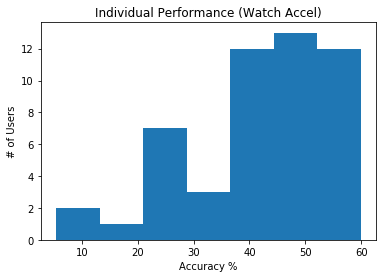

In [171]:
impersonalHistograms([x[2]*100 for x in impersonal_scores1], 'Accuracy %', '# of Users', 'Individual Performance (Watch Accel)')

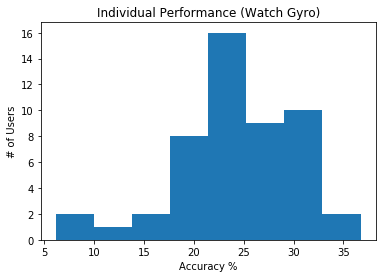

In [172]:
impersonalHistograms([x[2]*100 for x in impersonal_scores2], 'Accuracy %', '# of Users', 'Individual Performance (Watch Gyro)')

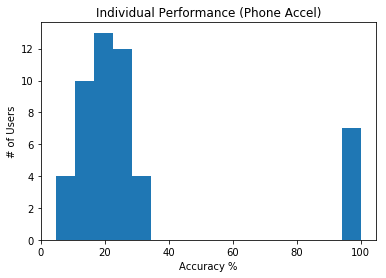

In [173]:
impersonalHistograms([x[2]*100 for x in impersonal_scores3], 'Accuracy %', '# of Users', 'Individual Performance (Phone Accel)')

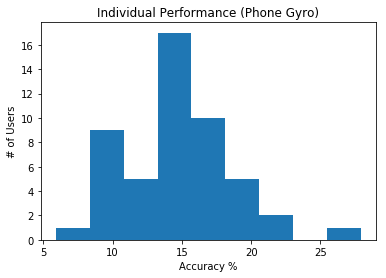

In [174]:
impersonalHistograms([x[2]*100 for x in impersonal_scores4], 'Accuracy %', '# of Users', 'Individual Performance (Phone Gyro)')

# Subset of Activities
<br>A. Non-hand-oriented - Walking, Jogging, Stairs, Sit, Stand, Kicking
<br>B. Hand-oriented (non-eating) - Dribbling, Catch, Typing, Writing, Clapping, Teeth, Folding
<br>C. Eating - Pasta, Soup, Sandwich, Chips, Drinking

## Personal

In [74]:
# Index (key) for subsets
groupA_activities = ['A', 'B', 'C', 'D', 'E', 'M']
groupB_activities = ['F', 'G', 'O', 'P', 'Q', 'R', 'S']
groupC_activities = ['H', 'I', 'J', 'K', 'L']

In [109]:
groupA_scores, groupA_cms = runPersonalModels(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupA_activities)],
                                                  algorithms, 'ACTIVITY')

0.972222222222
0.944444444444
0.898148148148
0.981481481481
0.944444444444
0.935185185185
0.888888888889
0.898148148148
0.87962962963
0.962962962963
0.87962962963
0.944444444444
0.888888888889
0.888888888889
0.759259259259
0.87962962963
0.824074074074
0.777777777778
0.907407407407
0.888888888889
0.796296296296
0.888888888889
0.796296296296
0.87962962963
0.916666666667
0.944444444444
0.916666666667
0.927272727273
0.927272727273
0.872727272727
0.935185185185
0.87962962963
0.888888888889
0.87037037037
0.805555555556
0.851851851852
0.907407407407
0.916666666667
0.833333333333
0.962962962963
0.907407407407
0.87962962963
0.925925925926
0.916666666667
0.833333333333
0.944444444444
0.855555555556
0.866666666667
0.935185185185
0.916666666667
0.888888888889
0.972222222222
0.944444444444
0.833333333333
0.940740740741
0.888888888889
0.837037037037
0.805555555556
0.824074074074
0.768518518519
0.919117647059
0.882352941176
0.772058823529
0.916666666667
0.888888888889
0.842592592593
0.953703703704
0.

In [105]:
groupA_scores, groupA_stds, groupA_cms = aggregateIndividualScores(groupA_scores, groupA_cms, groupA_activities)

In [106]:
groupA_cms[0]

,A,B,C,D,E,M,PER_ACT_ACC
A,1316,5,27,0,1,19,96.198830
B,41,1359,9,1,0,2,96.246459
C,32,37,1166,4,2,35,91.379310
D,9,8,44,1297,13,10,93.917451
E,8,3,25,29,1319,9,94.687724
M,23,16,53,6,14,1451,92.834293


In [107]:
groupA_scores

[0.94078377807675029, 0.91512553021723109, 0.87235900328004634]

In [108]:
groupA_stds

[0.036126271984378976, 0.049275966801690975, 0.077929412856948238]

In [80]:
groupB_scores, groupB_cms = runPersonalModels(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupB_activities)],
                                                  algorithms, 'ACTIVITY')

0.968992248062
0.906976744186
0.961240310078
0.952380952381
0.944444444444
0.912698412698
0.936507936508
0.880952380952
0.928571428571
0.968253968254
0.936507936508
0.97619047619
0.952380952381
0.928571428571
0.968253968254
0.936507936508
0.904761904762
0.944444444444
0.944444444444
0.888888888889
0.960317460317
0.968253968254
0.920634920635
0.968253968254
0.944444444444
0.849206349206
0.960317460317
0.919117647059
0.882352941176
0.926470588235
0.936507936508
0.944444444444
0.944444444444
0.968253968254
0.960317460317
0.952380952381
0.944444444444
0.888888888889
0.912698412698
0.952380952381
0.960317460317
0.992063492063
0.936507936508
0.857142857143
0.904761904762
0.936507936508
0.936507936508
0.944444444444
0.912408759124
0.897810218978
0.912408759124
0.972222222222
0.944444444444
0.953703703704
0.936708860759
0.905063291139
0.759493670886
0.92700729927
0.912408759124
0.861313868613
0.905660377358
0.911949685535
0.77358490566
0.97619047619
0.920634920635
0.97619047619
0.984126984127


In [81]:
groupB_scores, groupB_stds, groupB_cms = aggregateIndividualScores(groupB_scores, groupB_cms, groupB_activities)

In [82]:
groupB_cms[0]

,F,G,O,P,Q,R,S,PER_ACT_ACC
F,855,13,0,3,10,1,9,95.959596
G,11,877,1,2,3,7,9,96.373626
O,1,4,871,23,1,2,15,94.983642
P,0,0,53,865,3,3,4,93.211207
Q,9,5,13,22,872,2,20,92.470838
R,2,10,5,2,2,874,14,96.149615
S,2,13,14,4,3,19,868,94.041170


In [83]:
groupB_scores

[0.94817921806592609, 0.91228857648983464, 0.92168511914382956]

In [84]:
groupB_stds

[0.024739936503795322, 0.035103339890045028, 0.05791242271474481]

In [85]:
groupC_scores, groupC_cms = runPersonalModels(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupC_activities)],
                                                  algorithms, 'ACTIVITY')

0.922222222222
0.955555555556
0.966666666667
0.9
0.933333333333
0.844444444444
0.777777777778
0.666666666667
0.622222222222
0.8
0.833333333333
0.722222222222
0.877777777778
0.811111111111
0.777777777778
0.697916666667
0.635416666667
0.625
0.822222222222
0.8
0.777777777778
0.842105263158
0.778947368421
0.705263157895
0.745283018868
0.698113207547
0.698113207547
0.862745098039
0.794117647059
0.764705882353
0.811111111111
0.811111111111
0.811111111111
0.911111111111
0.933333333333
0.766666666667
0.913043478261
0.902173913043
0.79347826087
0.933333333333
0.911111111111
0.822222222222
0.644444444444
0.744444444444
0.677777777778
0.811111111111
0.744444444444
0.688888888889
0.844444444444
0.788888888889
0.8
0.844444444444
0.811111111111
0.611111111111
0.798245614035
0.80701754386
0.429824561404
0.777777777778
0.766666666667
0.811111111111
0.884955752212
0.929203539823
0.823008849558
0.866666666667
0.866666666667
0.711111111111
0.877777777778
0.777777777778
0.788888888889
0.744444444444
0.722

In [86]:
groupC_scores, groupC_stds, groupC_cms = aggregateIndividualScores(groupC_scores, groupC_cms, groupC_activities)

In [87]:
groupC_cms[0]

,H,I,J,K,L,PER_ACT_ACC
H,814,20,45,12,22,89.156627
I,29,738,43,30,76,80.567686
J,73,60,753,15,24,81.405405
K,26,64,34,772,49,81.693122
L,41,101,52,65,671,72.150538


In [88]:
groupC_scores

[0.80902643568719412, 0.77926771013888729, 0.73128363808414454]

In [89]:
groupC_stds

[0.082410776366438843, 0.0901684443024795, 0.098154257872554218]

## Impersonal

In [90]:
impersonal_groupA_scores, impersonal_groupA_cms = runImpersonalTests(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupA_activities)],
                                                  algorithms, 'ACTIVITY')
impersonal_groupA_scores, impersonal_groupA_stds, impersonal_groupA_cms = aggregateIndividualScores(impersonal_groupA_scores, impersonal_groupA_cms, groupA_activities)

0.935185185185
0.777777777778
0.824074074074
0.833333333333
0.574074074074
0.638888888889
0.75
0.638888888889
0.712962962963
0.824074074074
0.601851851852
0.555555555556
0.75
0.62962962963
0.675925925926
0.87962962963
0.842592592593
0.62962962963
0.833333333333
0.851851851852
0.777777777778
0.601851851852
0.481481481481
0.574074074074
0.888888888889
0.740740740741
0.787037037037
0.754545454545
0.672727272727
0.581818181818
0.87962962963
0.833333333333
0.657407407407
0.87037037037
0.842592592593
0.62037037037
0.833333333333
0.740740740741
0.583333333333
0.583333333333
0.564814814815
0.388888888889
0.87962962963
0.888888888889
0.768518518519
0.955555555556
0.866666666667
0.788888888889
0.944444444444
0.861111111111
0.666666666667
0.944444444444
0.833333333333
0.777777777778
0.555555555556
0.481481481481
0.17037037037
0.62037037037
0.601851851852
0.268518518519
0.205882352941
0.25
0.198529411765
0.833333333333
0.75
0.5
0.972222222222
0.87037037037
0.851851851852
0.712962962963
0.648148148

In [91]:
impersonal_groupB_scores, impersonal_groupB_cms = runImpersonalTests(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupB_activities)],
                                                  algorithms, 'ACTIVITY')
impersonal_groupB_scores, impersonal_groupB_stds, impersonal_groupB_cms = aggregateIndividualScores(impersonal_groupB_scores, impersonal_groupB_cms, groupB_activities)

0.945736434109
0.899224806202
0.868217054264
0.84126984127
0.666666666667
0.452380952381
0.944444444444
0.920634920635
0.849206349206
0.706349206349
0.698412698413
0.5
0.952380952381
0.865079365079
0.674603174603
0.936507936508
0.896825396825
0.952380952381
0.761904761905
0.746031746032
0.706349206349
0.611111111111
0.492063492063
0.603174603175
0.769841269841
0.666666666667
0.460317460317
0.882352941176
0.727941176471
0.816176470588
0.984126984127
0.801587301587
0.539682539683
0.952380952381
0.809523809524
0.65873015873
0.611111111111
0.515873015873
0.47619047619
0.968253968254
0.849206349206
0.920634920635
0.873015873016
0.825396825397
0.81746031746
0.920634920635
0.873015873016
0.896825396825
0.766423357664
0.598540145985
0.474452554745
0.888888888889
0.666666666667
0.777777777778
0.221518987342
0.196202531646
0.246835443038
0.846715328467
0.686131386861
0.510948905109
0.132075471698
0.0943396226415
0.0943396226415
0.730158730159
0.650793650794
0.404761904762
0.97619047619
0.9523809

In [92]:
impersonal_groupC_scores, impersonal_groupC_cms = runImpersonalTests(df_watch_accel.loc[df_watch_accel['ACTIVITY'].isin(groupC_activities)],
                                                  algorithms, 'ACTIVITY')
impersonal_groupC_scores, impersonal_groupC_stds, impersonal_groupC_cms = aggregateIndividualScores(impersonal_groupC_scores, impersonal_groupC_cms, groupC_activities)

0.677777777778
0.544444444444
0.588888888889
0.677777777778
0.566666666667
0.433333333333
0.633333333333
0.422222222222
0.455555555556
0.411111111111
0.333333333333
0.244444444444
0.644444444444
0.477777777778
0.444444444444
0.572916666667
0.479166666667
0.458333333333
0.666666666667
0.477777777778
0.444444444444
0.305263157895
0.389473684211
0.2
0.320754716981
0.169811320755
0.283018867925
0.352941176471
0.323529411765
0.372549019608
0.7
0.622222222222
0.466666666667
0.477777777778
0.4
0.311111111111
0.576086956522
0.467391304348
0.358695652174
0.5
0.222222222222
0.222222222222
0.511111111111
0.488888888889
0.422222222222
0.455555555556
0.455555555556
0.466666666667
0.566666666667
0.566666666667
0.366666666667
0.477777777778
0.444444444444
0.511111111111
0.0789473684211
0.105263157895
0.219298245614
0.488888888889
0.377777777778
0.311111111111
0.150442477876
0.230088495575
0.106194690265
0.288888888889
0.388888888889
0.166666666667
0.755555555556
0.577777777778
0.311111111111
0.533333

In [95]:
impersonal_groupA_cms[0]

,A,B,C,D,E,M,PER_ACT_ACC
A,631,4,203,9,5,62,69.037199
B,13,865,12,0,2,3,96.648045
C,187,14,623,14,4,59,69.145394
D,13,0,13,800,75,9,87.912088
E,10,0,8,161,737,20,78.739316
M,93,10,102,4,19,684,75.000000


In [96]:
impersonal_groupB_cms[0]

,F,G,O,P,Q,R,S,PER_ACT_ACC
F,718,7,1,1,155,2,7,80.583614
G,19,791,6,0,30,19,45,86.923077
O,12,6,759,68,31,7,34,82.769902
P,9,21,185,638,23,13,39,68.750000
Q,95,8,15,17,783,4,21,83.032874
R,17,64,39,18,24,735,12,80.858086
S,29,28,24,21,21,21,779,84.398700


In [97]:
impersonal_groupC_cms[0]

,H,I,J,K,L,PER_ACT_ACC
H,550,60,131,60,112,60.240964
I,108,483,84,91,150,52.729258
J,186,117,463,42,117,50.054054
K,67,95,62,573,148,60.634921
L,154,241,108,219,208,22.365591


In [98]:
impersonal_groupA_scores

[0.80053937214610116, 0.7295546495539057, 0.64429621645445134]

In [101]:
impersonal_groupA_stds

[0.14122968639021649, 0.13280690013496091, 0.14873701453775201]

In [99]:
impersonal_groupB_scores

[0.81920195243204574, 0.7459741579404402, 0.66133453343376725]

In [102]:
impersonal_groupB_stds

[0.17918869113620225, 0.17816980826527137, 0.17537683155423348]

In [100]:
impersonal_groupC_scores

[0.49766601701436886, 0.42023992613144784, 0.36371475697281869]

In [103]:
impersonal_groupC_stds

[0.15297012119679462, 0.12642288538292723, 0.10601884643638854]

# Train / Test Curve

## Personal Models

In [110]:
# Function to calculate the number of examples (and %) below a certain threshold for a dataframe
# For Activity Recognition, use the activity label name and user label name to find out how much missing data there is.
# Verbose option if you want the function to print everytime there are less than desired examples.
def findInstancesBelowThreshhold(df, label1, label2, threshold, verbose=False):
    count = 0
    total = 0
    for label1_val in df[label1].unique():
        for label2_val in df[label2].unique():
            examples = df.loc[(df[label1] == label1_val) & (df[label2] == label2_val)].shape[0]
            total += 1
            if (examples < threshold):
                if (verbose):
                    print("Below threshold! {:d} examples".format(examples))
                    print("Details:", label1_val, label2_val)
                count += 1

    print ("Examples below threshold:", count)
    print ("Total:", total)
    print("Percent: {:.2f}".format((count/total) * 100))

In [244]:
findInstancesBelowThreshhold(df_phone_accel, 'class', 'ACTIVITY', 17)
findInstancesBelowThreshhold(df_phone_gyro, 'class', 'ACTIVITY', 17)
findInstancesBelowThreshhold(df_watch_accel, 'class', 'ACTIVITY', 17, verbose=True)
findInstancesBelowThreshhold(df_watch_gyro, 'class', 'ACTIVITY', 17)

Examples below threshold: 8
Total: 900
Percent: 0.89
Examples below threshold: 17
Total: 900
Percent: 1.89
Below threshold! 0 examples
Details: 1616 B
Below threshold! 0 examples
Details: 1618 O
Below threshold! 0 examples
Details: 1642 C
Below threshold! 0 examples
Details: 1642 F
Examples below threshold: 4
Total: 900
Percent: 0.44
Examples below threshold: 4
Total: 900
Percent: 0.44


In [209]:
# Function to pool n examples for each activity
# Used in runCustomPersonalModels
def pool(df, label, no_samples):
    pool = pd.DataFrame()
    for i in df[label].unique():
        x = df.loc[df[label] == i].sample(no_samples)
        pool = pool.append(x)
    return pool

In [186]:
# Same as runPersonalModels except with controls for number of train and test examples.
# To generate personal training curves.
def runCustomPersonalModels(df, algorithm, label_name, no_train, no_test, iterations, min_data):
    # List to hold scores (list of lists since there are several algorithms per user)
    individual_scores = []

    
    # Build a model per user
    for user in df['class'].unique():
        scores = []
        data = df.loc[df['class'] == user]
    
        for i in range(iterations):
            # Randomly sample for both training and test data to avoid drawing same example
            train_and_test = pool(data, label_name, no_train + no_test)
            # Sample test from above
            test_data = pool(train_and_test, label_name, no_test)
            # Drop test examples to get train examples
            train_data = train_and_test.drop(test_data.index)
            
            if ((train_data.shape[0] < no_train * min_data) | (test_data.shape[0] < no_test * min_data)):
                print(user)
                break
        
            algorithm.fit(train_data.drop(label_name, axis=1), train_data[label_name])
            predicted = algorithm.predict(test_data.drop(label_name, axis=1))

            # Accuracy: % of Correctly Classified Labels
            # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
            accuracy = accuracy_score(test_data[label_name], predicted)

            # Output Status
            print(user, accuracy)

            # Add score and confusion matrix
            scores.append(accuracy)

        # Add score for the user
        individual_scores.append(scores)


    return individual_scores

In [174]:
means, stds = [], []

for i in range(1, 15):
    # i is train amount, 3 test, 10 iterations for each i, use only data with 17+ examples
    scores = runCustomPersonalModels(df_watch_accel, algorithms[0], 'ACTIVITY', i, 3, 10, 17)
    
    # Remove results with too little data
    scores = [x for x in scores if x != []]
    
    mean = np.mean([np.mean(x) for x in scores])
    std = np.std([np.mean(x) for x in scores])
    means.append(mean)
    stds.append(std)

1600 0.666666666667
1600 0.592592592593
1600 0.62962962963
1600 0.611111111111
1600 0.481481481481
1600 0.592592592593
1600 0.574074074074
1600 0.592592592593
1600 0.537037037037
1600 0.703703703704
1601 0.703703703704
1601 0.555555555556
1601 0.518518518519
1601 0.740740740741
1601 0.574074074074
1601 0.537037037037
1601 0.611111111111
1601 0.592592592593
1601 0.555555555556
1601 0.62962962963
1602 0.481481481481
1602 0.407407407407
1602 0.481481481481
1602 0.388888888889
1602 0.537037037037
1602 0.407407407407
1602 0.518518518519
1602 0.555555555556
1602 0.407407407407
1602 0.574074074074
1603 0.555555555556
1603 0.425925925926
1603 0.611111111111
1603 0.518518518519
1603 0.592592592593
1603 0.518518518519
1603 0.407407407407
1603 0.574074074074
1603 0.462962962963
1603 0.685185185185
1604 0.592592592593
1604 0.462962962963
1604 0.444444444444
1604 0.5
1604 0.37037037037
1604 0.388888888889
1604 0.462962962963
1604 0.462962962963
1604 0.574074074074
1604 0.444444444444
1605 0.4814814

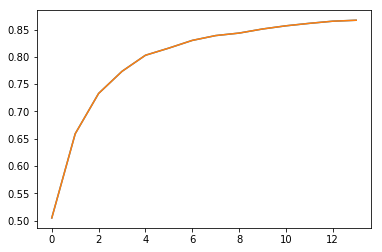

In [265]:
plt.plot(means)
plt.show()

In [185]:
stds

[0.070856075437542701,
 0.071982771678996429,
 0.06930209855158348,
 0.068648116612222143,
 0.058926446317920149,
 0.057852307386142915,
 0.055006824788280867,
 0.051924355669434347,
 0.047304967118551235,
 0.04782905558818222,
 0.047295003778781118,
 0.045903142240637768,
 0.044056128834521473,
 0.04161917715236315]

## Impersonal Models

In [250]:
# Function to pool n examples for each activity
# Used in runCustomPersonalModels
def multiUserPool(df, user_label, label, no_samples):
    multi_pool = pd.DataFrame()
    for user in df[user_label].unique():
        p = pool(df.loc[df[user_label] == user], label, no_samples)
        multi_pool = multi_pool.append(p)
    return multi_pool

In [259]:
## Function that buids and tests a list of given machine learning algorithms.
# Inputs: DataFrame (data),
#         List of algorithms (from sklearn - e.g. sklearn.tree.DecisionTreeClassifier),
#         Name of label being tested (e.g. 'ACTIVITY' for Activity Recognition,
def runCustomImpersonalModels(df, algorithm, label_name, user_size, example_size):
    # List to hold scores (list of lists since there are several algorithms per user)
    individual_scores = []
    
    # Build a model per user (as the test data)
    for user in df['class'].unique():
        scores = []
        
        # Split data into training and test. Training data is every user except one, test is remaining user
        train_set = df.loc[df['class'] != user]
        subset = random.sample(set(train_set['class'].unique()), user_size)
        available_train_data = df.loc[df['class'].isin(subset)]
        test_data = df.loc[df['class'] == user]

        # Pool m examples per user from all available training data
        train_data = multiUserPool(available_train_data, 'class', label_name, example_size)

        # Build model and predict
        algorithm.fit(train_data.drop(label_name, axis=1), train_data[label_name])
        predicted = algorithm.predict(test_data.drop(label_name, axis=1))

        # Accuracy: % of Correctly Classified Labels
        # See http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
        accuracy = accuracy_score(test_data[label_name], predicted)

        # Output Status
        print(user, subset)
        print('Users:', user_size, 'Examples:', example_size, 'Acc:', accuracy)

        # Add score
        scores.append(accuracy)
        
        # Add score for the user
        individual_scores.append(scores)

    return individual_scores

In [273]:
i_means, i_stds = [], []
for i in range(5, 50, 5):
    i_score = runCustomImpersonalModels(df_watch_accel, algorithms[0], 'ACTIVITY', i, 1)
    i_means.append(np.mean(i_score))
    i_stds.append(np.std(i_score))

1600 [1613, 1624, 1631, 1610, 1616]
Users: 5 Examples: 1 Acc: 0.65749235474
1601 [1617, 1622, 1602, 1609, 1629]
Users: 5 Examples: 1 Acc: 0.416666666667
1602 [1619, 1636, 1648, 1624, 1620]
Users: 5 Examples: 1 Acc: 0.432098765432
1603 [1636, 1622, 1602, 1620, 1617]
Users: 5 Examples: 1 Acc: 0.364197530864
1604 [1612, 1629, 1611, 1608, 1618]
Users: 5 Examples: 1 Acc: 0.385802469136
1605 [1603, 1645, 1619, 1631, 1629]
Users: 5 Examples: 1 Acc: 0.39696969697
1606 [1645, 1608, 1625, 1624, 1632]
Users: 5 Examples: 1 Acc: 0.41975308642
1607 [1645, 1608, 1613, 1618, 1649]
Users: 5 Examples: 1 Acc: 0.191489361702
1608 [1620, 1648, 1624, 1617, 1646]
Users: 5 Examples: 1 Acc: 0.241176470588
1609 [1622, 1648, 1638, 1639, 1641]
Users: 5 Examples: 1 Acc: 0.324712643678
1610 [1601, 1621, 1646, 1648, 1613]
Users: 5 Examples: 1 Acc: 0.382716049383
1611 [1617, 1612, 1646, 1624, 1619]
Users: 5 Examples: 1 Acc: 0.435185185185
1612 [1626, 1621, 1607, 1629, 1635]
Users: 5 Examples: 1 Acc: 0.337423312883
16

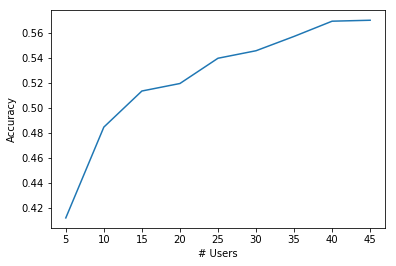

In [274]:
plt.plot(range(5, 50, 5), i_means)
plt.xlabel('# Users')
plt.ylabel('Accuracy')
plt.show()

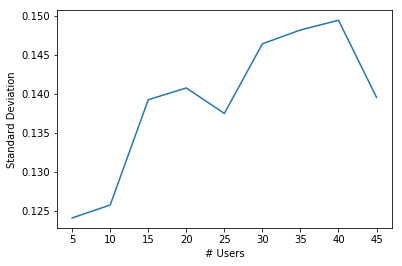

In [275]:
plt.plot(range(5, 50, 5), i_stds)
plt.xlabel('# Users')
plt.ylabel('Standard Deviation')
plt.show()